In [1]:
import gc
import itertools
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

import comet_ml
import tensorflow as tf
import torch
import torch.optim as optim
from load_data import load_data
from model import init_model
from rsl_depth_completion.conditional_diffusion.config import cfg as cfg_cls
from rsl_depth_completion.conditional_diffusion.custom_trainer import ImagenTrainer
from rsl_depth_completion.conditional_diffusion.utils import (
    dict2mdtable,
    log_params_to_exp,
)
from rsl_depth_completion.diffusion.utils import set_seed
from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    get_ds_kwargs,
    setup_train_pipeline,
)
from rsl_depth_completion.conditional_diffusion.data_utils import (
    update_eval_batch_file,
    fill_eval_batch_with_coco,
)


torch.backends.cudnn.benchmark = True

In [15]:

logdir_name = "debug"
# logdir_name = "standalone_trainer"
cfg, train_logdir = setup_train_pipeline("./configs/overfit.yaml", logdir_name)
cfg.disabled = True
cfg.input_res = 256
cfg.unets_output_res = [64, 256]
cfg.use_triplet_loss=False

# cfg.cond_img_sdm_interpolation_mode = "kbnet"

ds_kwargs = get_ds_kwargs(cfg)

ds, train_dataloader, val_dataloader = load_data(
    ds_name=cfg.ds_name, do_overfit=cfg.do_overfit, cfg=cfg, **ds_kwargs
)
x=ds[0]
eval_batch = ds.eval_batch
# eval_batch = torch.utils.data.default_collate([ds[210],ds[40]])
# eval_batch = {k:v[:cfg.batch_size] for k,v in torch.load("eval_batch_rand_sdm.pt")[cfg.input_res].items()}

print(x['cond_img'].shape)

torch.Size([1, 256, 256])


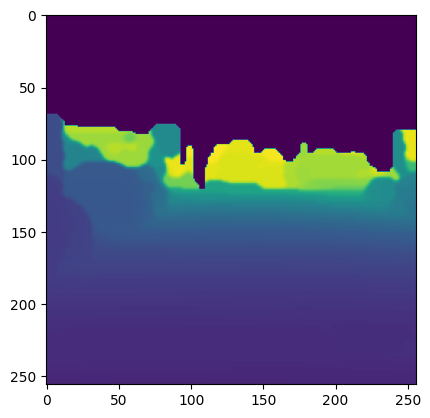

In [16]:

plt.imshow(eval_batch['sdm'][0].detach().squeeze().numpy())
plt.imshow(eval_batch['cond_img'][0].detach().squeeze().numpy())
# plt.imshow(eval_batch['rgb'][0].detach().squeeze().numpy().transpose(1,2,0))

In [4]:
sample0_idx = 310 + 5
sample1_idx = 80 + 5
eval_batch = torch.utils.data.default_collate([ds[sample0_idx], ds[sample1_idx]])
# plot_batch(eval_batch)

do_resave_eval_batch = False
update_eval_batch_file(
    eval_batch,
    cfg,
    image_paths=[ds.ds.image_paths[sample0_idx], ds.ds.image_paths[sample1_idx]],
    do_resave_eval_batch=do_resave_eval_batch,
    filename="eval_batch.pt",
)

saved for 160


In [43]:
def plot_batch(batch,keys = ['sdm', 'rgb', 'cond_img', 'input_img']):
    fig, axs = plt.subplots(cfg.batch_size, len(keys), figsize=(12, 5))
    key_to_full_name = {
    'sdm': 'sparse depth',
    'rgb': 'RGB',
    'cond_img': 'conditional image',
    'input_img': 'input image',
}
    for sample_idx in range(cfg.batch_size):
        
        for idx, key in enumerate(keys):
            x = batch[key][sample_idx].permute(1,2,0)
            axs[sample_idx, idx].imshow(x/x.max())
            if sample_idx == 0:
                axs[sample_idx, idx].set_title(key_to_full_name.get(key, key))
        axs[sample_idx, 0].set_ylabel(f"sample {sample_idx}")

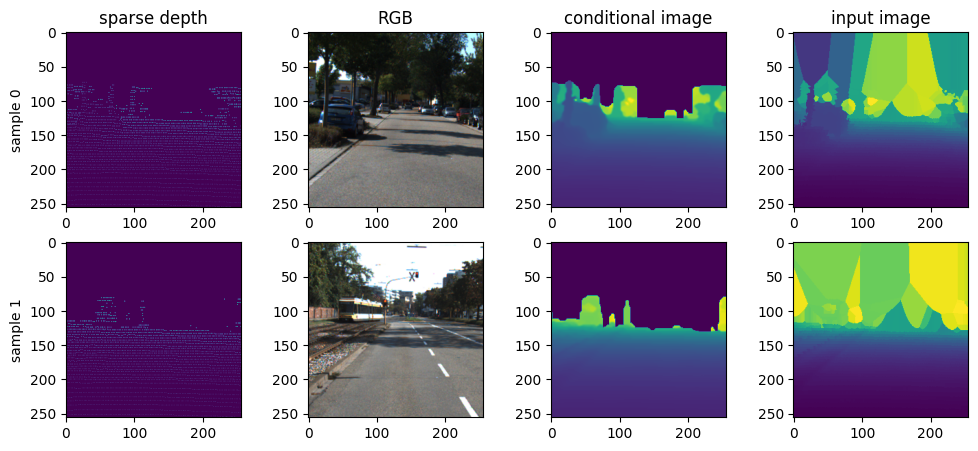

In [10]:
plot_batch(eval_batch)

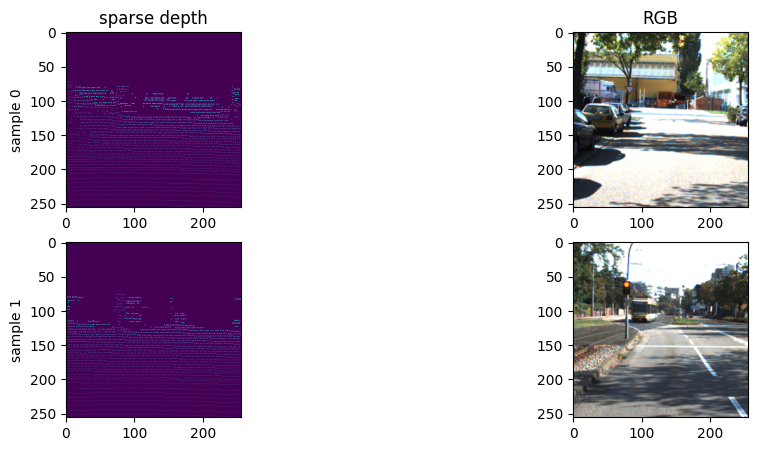

In [44]:
path = "eval_batch.pt"
loaded_eval_batch = torch.load(path)
loaded_eval_batch = {k:v[:cfg.batch_size] for k,v in loaded_eval_batch[cfg.input_res].items() if k not in ['info']}
plot_batch(loaded_eval_batch,keys = ['sdm', 'rgb'])